## Библиотеки

Первым этапом анализа данных и тренировки модели является импортирование нужных библиотек. Если у вас нет нужных библиотек, установите их в терминале командой `pip install [название библиотеки]`

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score

## Датасет

Прежде, чем выбирать модель, нужно проанализировать датасет на возможные "аномалии" и привести его в подходящий вид.

In [2]:
df_train = pd.read_csv('train_cars.csv', index_col=0)
df_test = pd.read_csv('answer_cars.csv', index_col=0)

In [3]:
df_train.head()

,buying_price,maint_price,doors_count,person_count,lug_boot_size,safety,class
0,3,2,больше,4,2,2,0
1,1,3,3,4,1,2,1
2,2,0,4,больше,0,2,1
3,0,1,2,2,2,2,0
4,1,0,больше,2,1,0,0


Поймем, что значат наши признаки и целевая переменная. 



| Название переменной | Роль            | Тип            | Описание                                       | Значения                                                |
|---------------------|-----------------|----------------|------------------------------------------------|---------------------------------------------------------|
| buying_price        | Признак         | Категорический | Цена покупки                                   | 0 - низкая, 1 - средняя, 2 - высокая, 3 - очень высокая |
| maint_orice         | Признак         | Категорический | Цена обслуживания                              | 0 - низкая, 1 - средняя, 2 - высокая, 3 - очень высокая |
| doors_count         | Признак         | Категорический | Количество дверей                              | 2, 3, 4 и больше                                        |
| person_count        | Признак         | Категорический | Вместимость (людей для перевозки)             | 2, 4 и больше                                           |
| lug_boot_size       | Признак         | Категорический | Размер багажника                               | 0 - маленький, 1 - средний, 2 - большой                  |
| safety              | Признак         | Категорический | Предполагаемая безопасность автомобиля         | 0 - низкая, 1 - средняя, 2 - высокая                     |
| class               | Целевая переменная | Категорический | Оценка                                         | 0 - неприемлемая, 1 - приемлемая, 2 - хорошая, 3 - очень хорошая |


Заметим, что в столбцах "doors_count" и "person_count" помимо числовых значений возможно значение "больше". Для того, чтобы применить модель классификации, нам нужно перевести это значение в числовое. Это можно сделать разными способами: закодировать цифрой (например, 5, но можно кастомизировать кодировку) или, поскольку «больше» указывает на четыре или более дверей (или на 5 и больше человек в машине), вы можете рассмотреть возможность бинаризации этого столбца. Например, вы можете создать четыре двоичных столбца: «двери_2», «двери_3», «двери_4» и «двери_5больше», где каждый столбец указывает, имеет ли машина столько или больше дверей. Поэкспериментируйте и поймите, что дает лучшие результаты классификации! 

Для целей этого туториала мы закодируем "больше" цифрой 5:

In [4]:
mapping = {'2':2, '3':3, '4':4,'больше': 5} 
df_train['doors_count'] = df_train['doors_count'].map(mapping)
df_train['person_count'] = df_train['person_count'].map(mapping)
df_test['doors_count'] = df_test['doors_count'].map(mapping)
df_test['person_count'] = df_test['person_count'].map(mapping)

## Первичный анализ данных

Посмотрим, как распределятся все характеристики датафрейма. Может, есть признаки, где распределение классов неравномерное? 

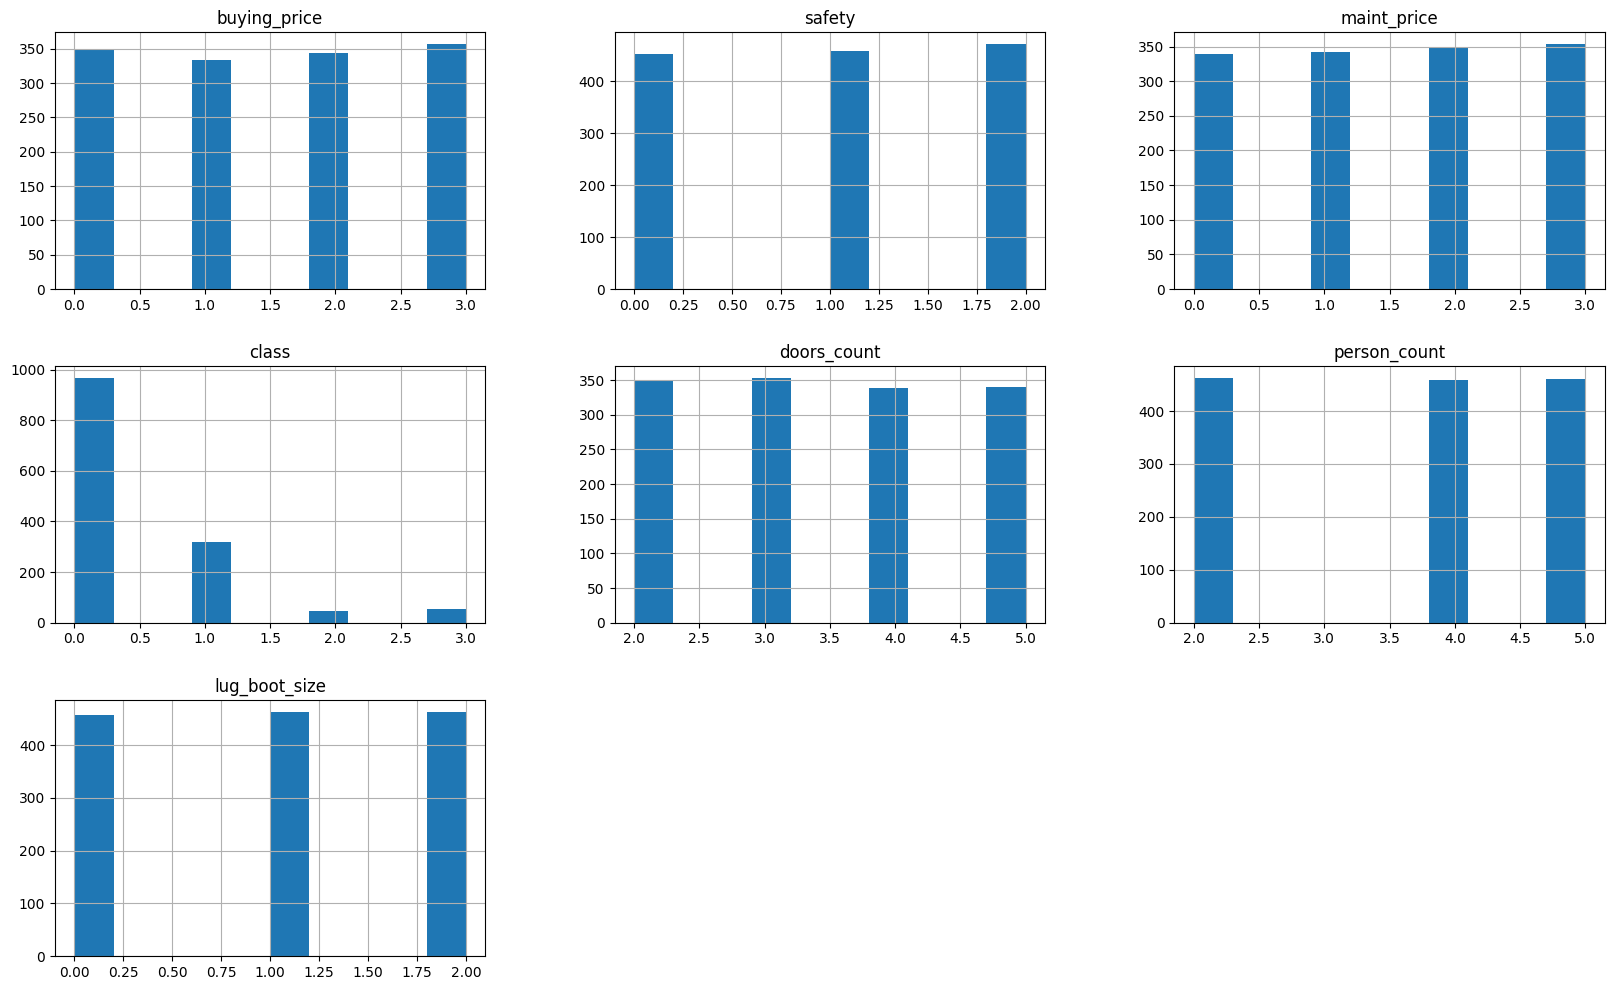

In [5]:
features = list(set(df_train.columns) - set(['DateTime']))

_ = df_train[features].hist(figsize=(20,12))

Все классы имеют примерно одно и то же количество значений, но в целевой переменной гораздо больше "неприемлимых" по качеству машин, чем приемлимых, хороших и очень хороших. Может, с этим можно что-то сделать?

Посмотрим на то, как значения корррелируют между собой. Если какая-то пара значений имеет большой коэффициент, то одно из них можно выкинуть.

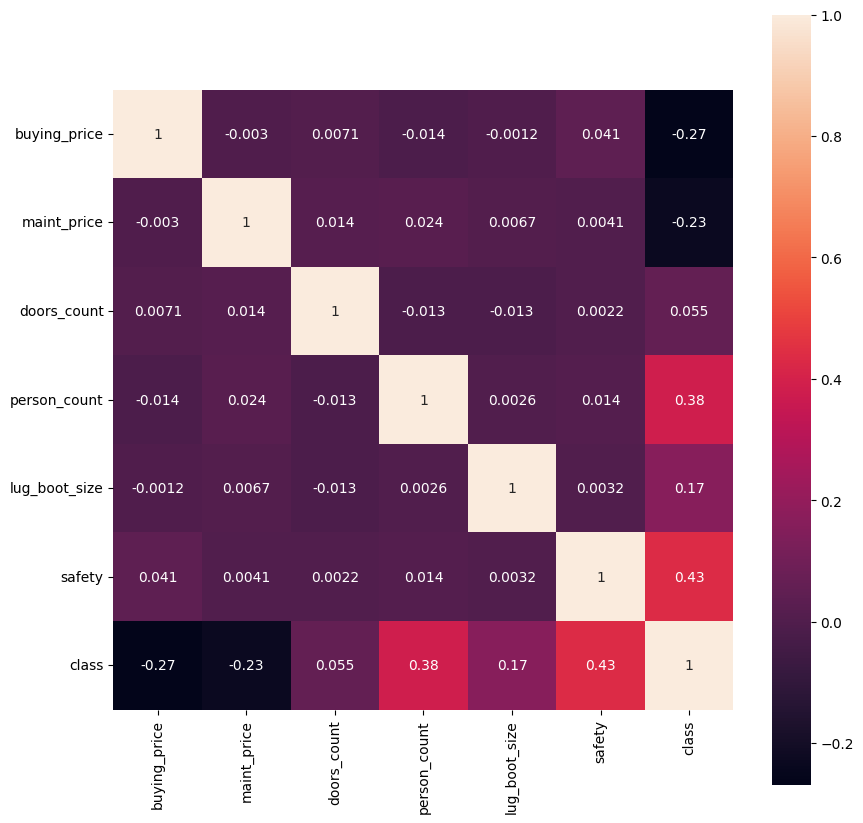

In [6]:
plt.rcParams['figure.figsize']=(10,10)

corr = df_train.corr()
g = sns.heatmap(corr, square = True, annot=True)

Посмотрите, есть ли значимые корреляции? Нужно ли убрать какие-то признаки?

## Предобработка данных

Нужно ли как-то дополнительно обработать датасет? Проанализируйте, есть ли что-то, что можно изменить.





Приступим к созданию собственной **обучающей** и **тестовой** выборки. Вы можете изменить размер тестовой выборки и random_state, если посчитаете нужным.

In [7]:
X = df_train.drop(["class"], axis = 1)
y = df_train["class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
X_train.head()

,buying_price,maint_price,doors_count,person_count,lug_boot_size,safety
415,2,1,3,5,0,2
371,2,0,4,4,2,1
716,0,1,2,5,0,0
1089,0,3,4,2,0,1
1107,3,3,5,4,1,2


## Выбор модели обучения
Есть множество моделей классификации, каждая из которых имеет свои плюсы и минусы. Попробуйте разные варианты (Например, логистическую регрессию или деревья решений) и выберите тот, что дает наилучшие результаты.

**Важно**: *не забывайте, что у каждой модели есть свои параметры, которые стоить изменить для улучшения качества работы модели.*

В данном туториале мы используем Наивный Байессовский Классификатор.

In [10]:
clf = GaussianNB()

In [11]:
clf.fit(X_train, y_train)

GaussianNB()

За счет обученой модели **предскажем** значения целового столбца.

In [12]:
y_pred = clf.predict(X_test)

В качестве метрики оценки оценивания качества модели будем использовать **F1 score (macro)**, так как он используется в оценке решений. Оценка F1 (F-мера) – среднее значение Точности измерений (Accuracy) и Отзыва (Recall).

In [13]:
f1 = f1_score(y_test, y_pred, average= 'macro')
print("F1 мера бейзлайна:", f1)

F1 мера бейзлайна: 0.5162789090807667


После получения метрики оценки качества, подумайте: можно ли улучшить качество модели? Может, стоит убрать какие-то признаки, и тогда качество повысится? Не бойтесь экспериментировать!

## Генерация ответа

In [14]:
X = df_test.drop(["class"], axis = 1)

In [15]:
df_test["class"] = clf.predict(X)

In [16]:
df_test.head()

,buying_price,maint_price,doors_count,person_count,lug_boot_size,safety,class
0,2,3,5,2,2,0,0
1,1,2,2,2,1,1,0
2,1,0,2,5,0,1,1
3,1,2,5,5,1,1,1
4,1,1,5,4,0,2,3


In [17]:
df_test.sort_index().to_csv("submit.csv")